In [1]:
import tensorflow as tf
from tensorflow import keras
import gym

In [2]:
env = gym.make("CartPole-v1")
obs = env.reset(seed=42)

In [3]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [4]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [5]:
import matplotlib.pyplot as plt

def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

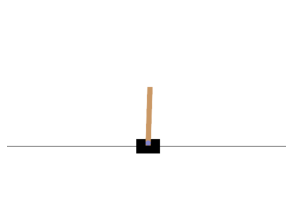

In [6]:
plot_environment(env)
plt.show()

In [7]:
env.action_space

Discrete(2)

In [8]:
action = 1
obs, reward, done, info = env.step(action)

In [9]:
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

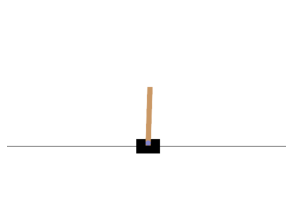

In [10]:
plot_environment(env)
plt.show(env)

In [11]:
reward

1.0

In [12]:
done

False

In [13]:
info

{}

In [14]:
if done:
    obs = env.reset()

In [15]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []

for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs) 
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [16]:
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.18, 9.015963620157304, 24.0, 72.0)

In [17]:
frames = []

obs = env.reset()
for step in range(100):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [18]:
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval)
    plt.close()
    return anim

In [19]:
plot_animation(frames)

In [20]:
keras.backend.clear_session()

n_inputs = 4

model = keras.models.Sequential([ 
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [21]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    np.random.seed(seed)
    obs = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [22]:
frames = render_policy_net(model)
plot_animation(frames)

In [23]:
n_environments = 50
n_iterations = 5000
np.random.seed(42)
envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
observations = [env.reset(seed=seed) for seed, env in enumerate(envs)]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print(f"\rIteration: {iteration}, Loss: {loss.numpy():.3f}", end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.127

In [24]:
frames = render_policy_net(model)
plot_animation(frames)